In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import lmfit
from hydropt.iops import IOP_model, ThreeCompModel_OLCI, FiveCompModel, OLCI_WBANDS
from hydropt.hydropt import PolynomialForward, InversionModel

../hydropt/iops.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pico_siop.loc[710,:] = [0,0]
../hydropt/iops.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nano_siop.loc[710,:] = [0,0]
../hydropt/iops.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  micro_siop.loc[710,:] = [0,0]


In [131]:
plt.rcParams['figure.figsize'] = (14,8)
plt.style.use('ggplot')

### Station #19

#### Regional SIOPs

Here we specify the regional specific SIOPs for station 19

In [3]:
st019_aph = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/station_019/aph.csv', index_col='wavelength')
st019_bb_tot = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/station_019/bb.csv', index_col='wavelength')

In [4]:
new_index = np.sort(np.unique(np.append(st019_aph.index.values, OLCI_WBANDS)))
st019_aph = st019_aph\
                    .reindex(new_index)\
                    .interpolate()\
                    .loc[OLCI_WBANDS]

In [5]:
# see excel Hans email 10/06
bb_tot = lambda x: 2001.7*x**-2.186

We also know that the phytoplankton composition is roughly made up 50% nano (0.27 $mg\ m^{-3}$) and 50% micro (0.29 $mg\ m^{-3}$). We can use the nano and micro phytoplankton backscatter models to calculate the total backscatter due to phytoplankton. 

In [62]:
five_comp_iop = FiveCompModel()
bb_phyto = five_comp_iop.get_iop(nano=.27, micro=.29, pico=.09).sum(axis=0)[1]

In [63]:
bb_star_nap = (bb_tot(OLCI_WBANDS)-bb_phyto)/.175

In [64]:
def st019_cdom(*args):
    
    def iop(a_440=args[0]):       
        a = a_440*np.exp(-0.0179*(OLCI_WBANDS-440))
        bb = np.zeros(len(OLCI_WBANDS))

        return np.array([a, bb])
    
    def gradient():
        return None
    
    return iop, gradient
    
def st019_nap(*args):
    
    def iop(tss=args[0]):
        a_440_star = .0054/.175
        a = tss*a_440_star*np.exp(-.0065*(OLCI_WBANDS-440))
        bb = tss*bb_star_nap

        return np.array([a, bb])
    
    def gradient():
        return None
    
    return iop, gradient

def st019_phyto(*args):
    
    def iop(chl=args[0]):
        a_star = (st019_aph/.65).absorbance
        a = a_star*chl
        bb = (chl/(.27+.29+.09))*bb_phyto

        return np.array([a, bb])
    
    def gradient():
        return None
    
    return iop, gradient

Lets specify a 3 component model that describe the regional SIOPS

In [65]:
three_comp = IOP_model()
three_comp.set_iop(
    wavebands=OLCI_WBANDS,
    cdom = st019_cdom,
    nap=st019_nap,
    chl=st019_phyto)

In [66]:
a_tot = st019_aph.absorbance + st019_nap(.175)[0]()[0] + st019_cdom(.0178)[0]()[0]

#### OLCI reflectance

In [67]:
olci_rrs = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/olci_rrs.csv')
st019_insitu_rrs = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/station_019/rrs_insitu.csv')

Note that station 19 has invalid **flags**!

In [68]:
# get 3x3 average of olci rrs at station 19
st019_olci_rrs = olci_rrs\
                        .set_index(['station_id', 'window', 'flag'])\
                        .loc[19, 3, False]
# convert ids to floats
st019_olci_rrs.index = [float(i) for i in st019_olci_rrs.index]

In [69]:
st019_insitu_rrs = st019_insitu_rrs.set_index('wavelength').rrs

Text(0.5, 0.98, 'station 19')

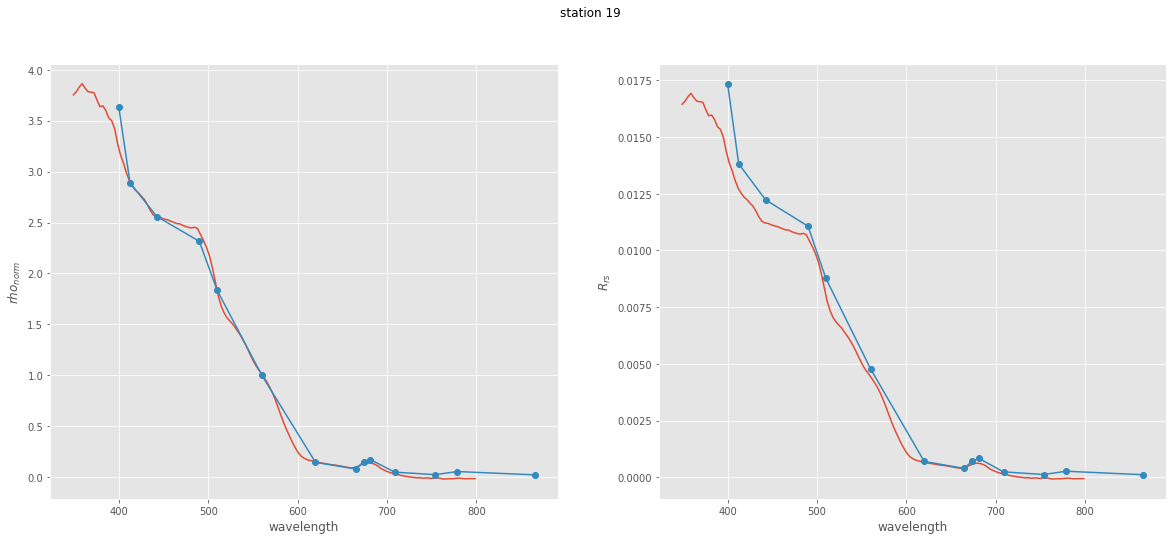

In [70]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].plot(st019_insitu_rrs/st019_insitu_rrs.loc[560.95])
ax[0].plot(st019_olci_rrs/st019_olci_rrs.loc[560], marker='o')
ax[0].set_xlabel('wavelength')
ax[0].set_ylabel('$rho_{norm}$')

ax[1].plot(st019_insitu_rrs)
ax[1].plot(st019_olci_rrs, marker='o')
ax[1].set_xlabel('wavelength')
ax[1].set_ylabel('$R_{rs}$')

fig.suptitle('station 19')

### Inversion

In [106]:
b = ThreeCompModel_OLCI()
b.set_iop(wavebands=OLCI_WBANDS, chl=st019_phyto)
fwd_olci = PolynomialForward(three_comp)

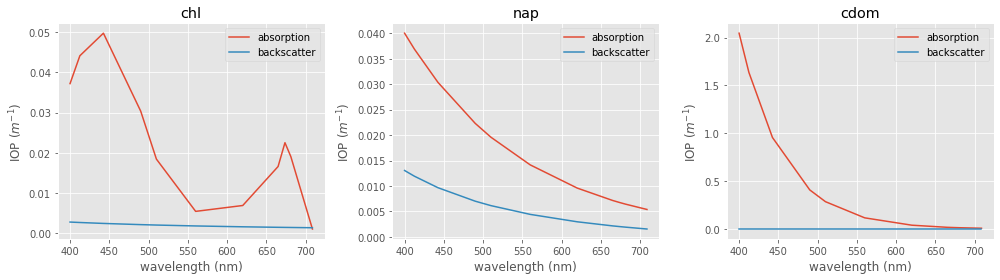

In [118]:
three_comp.plot(chl=1, nap=1, cdom=1)

In [108]:
inv_olci = InversionModel(fwd_model=fwd_olci, minimizer=lmfit.minimize)

In [109]:
# select OLCI rrs bands
olci_rrs_vis = st019_olci_rrs.loc[400:708.75]
olci_rrs_vis = olci_rrs_vis/np.pi

In [110]:
# set initial guess parameters close to measured values
x0 = lmfit.Parameters()
x0.add('cdom', value=.02, min=1E-9, max=10)
x0.add('nap', value=.1, min=1E-9, max=20)
x0.add('chl', value=.6, min=1E-9, max=10)

In [111]:
weights = np.repeat(1,11)
weights[0] = 1E-9
# weights[2] = 5
# # weights[7] = 5
# # weights[8] = 5
# weights[9] = 5
weights[10] = 1E-9

In [112]:
res = inv_olci.invert(x0, olci_rrs_vis, w=weights)

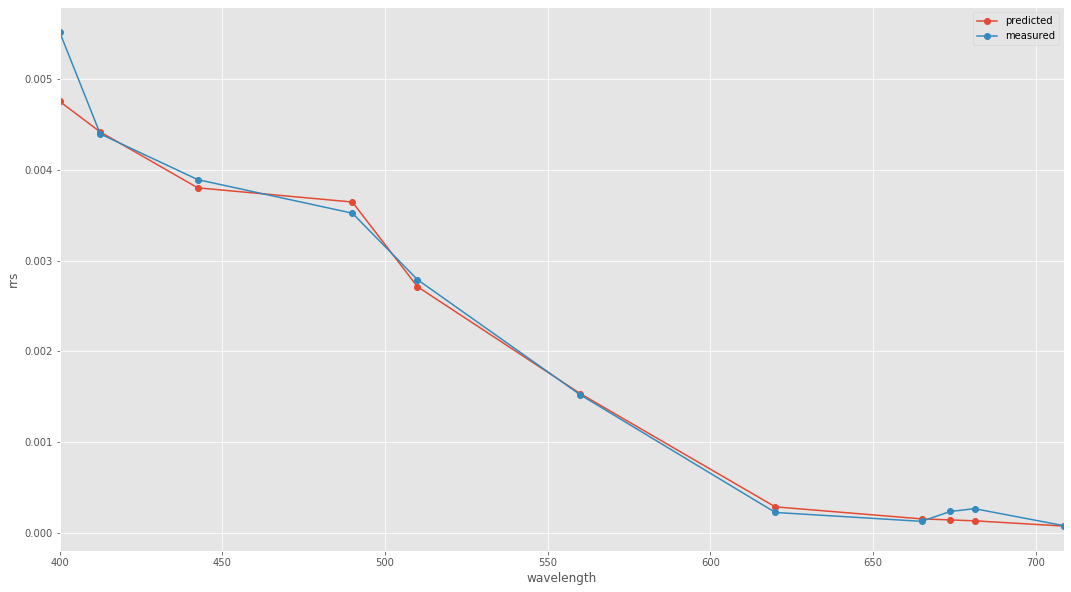

In [113]:
res.rrs.plot(marker='o', label='predicted')
olci_rrs_vis.plot(marker='o', label='measured')
plt.legend()

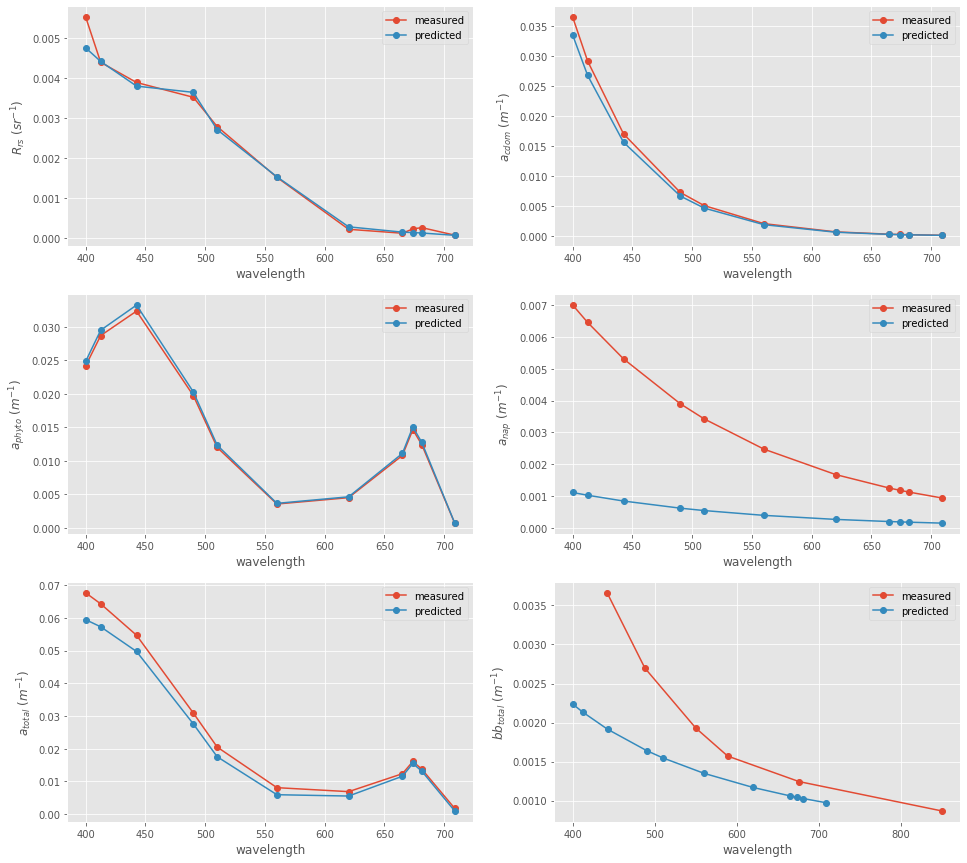

In [122]:
f, ax = plt.subplots(3,2, figsize=(16,15))

ax[0][0].plot(olci_rrs_vis, marker='o', label='measured')
ax[0][0].plot(OLCI_WBANDS, res.rrs, marker='o', label='predicted')
ax[0][0].set_xlabel('wavelength')
ax[0][0].set_ylabel('$R_{rs}\ (sr^{-1})$')
ax[0][0].legend()

ax[0][1].plot(OLCI_WBANDS, st019_cdom(.0178)[0]()[0], marker='o', label='measured')
ax[0][1].plot(OLCI_WBANDS, res.iops.sel(comp='cdom', iop='absorption'), marker='o', label='predicted')
ax[0][1].set_xlabel('wavelength')
ax[0][1].set_ylabel('$a_{cdom}\ (m^{-1})$')
ax[0][1].legend()

ax[1][0].plot(OLCI_WBANDS, st019_aph, marker='o', label='measured')
ax[1][0].plot(OLCI_WBANDS, res.iops.sel(comp='chl', iop='absorption'), marker='o', label='predicted')
ax[1][0].set_xlabel('wavelength')
ax[1][0].set_ylabel('$a_{phyto}\ (m^{-1})$')
ax[1][0].legend()

ax[1][1].plot(OLCI_WBANDS, st019_nap(.175)[0]()[0], marker='o', label='measured')
ax[1][1].plot(OLCI_WBANDS, res.iops.sel(comp='nap', iop='absorption'), marker='o', label='predicted')
ax[1][1].set_xlabel('wavelength')
ax[1][1].set_ylabel('$a_{nap}\ (m^{-1})$')
ax[1][1].legend()

ax[2][0].plot(OLCI_WBANDS, a_tot, marker='o', label='measured')
ax[2][0].plot(OLCI_WBANDS, res.iops.sel(iop='absorption').sum(axis=0), marker='o', label='predicted')
ax[2][0].set_xlabel('wavelength')
ax[2][0].set_ylabel('$a_{total}\ (m^{-1})$')
ax[2][0].legend()

ax[2][1].plot(st019_bb_tot, marker='o', label='measured')
ax[2][1].plot(OLCI_WBANDS, res.iops.sel(iop='backscatter').sum(axis=0), marker='o', label='predicted')
ax[2][1].set_xlabel('wavelength')
ax[2][1].set_ylabel('$bb_{total}\ (m^{-1})$')
ax[2][1].legend()

# plt.plot(st019_bb_tot, label='measured')
# res.iops.sel(iop='backscatter').sum(axis=0).plot(label='predicted')

#### Closure

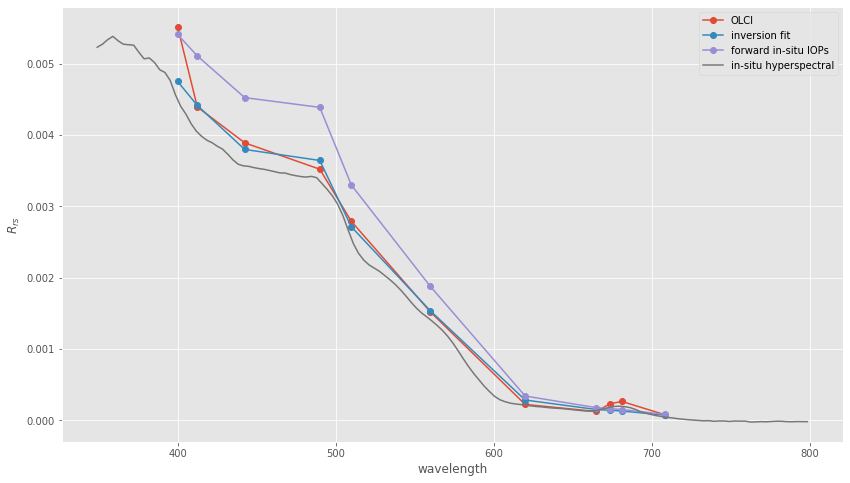

In [132]:
plt.plot(olci_rrs_vis, label='OLCI', marker='o')
plt.plot(OLCI_WBANDS, fwd_olci.forward(cdom=.01634, nap=.02778, chl=0.67), label='inversion fit', marker='o')
plt.plot(OLCI_WBANDS, fwd_olci.refl_model.forward(np.array([a_tot, bb_tot(OLCI_WBANDS)])), label='forward in-situ IOPs', marker='o')
plt.plot(st019_insitu_rrs/np.pi, label='in-situ hyperspectral')

plt.xlabel('wavelength')
plt.ylabel('$R_{rs}$')
plt.legend()

### Inversion 5 comp

In [638]:
five_comp_model = FiveCompModel()
#five_comp_model.set_iop(wavebands=OLCI_WBANDS, nap=st019_nap, cdom=st019_cdom)
# remove picos
#five_comp_model.iop_model.pop('pico')
fwd_olci_5comp = PolynomialForward(five_comp_model)

In [639]:
inv_olci_5comp = InversionModel(fwd_model=fwd_olci_5comp, minimizer=lmfit.minimize)

In [640]:
# set initial guess parameters close to measured values
x0_1 = lmfit.Parameters()
x0_1.add('cdom', value=.02, min=1E-9, max=10)
x0_1.add('nap', value=.1, min=1E-9, max=20)
x0_1.add('pico', value=.09, min=1E-9, max=10)
x0_1.add('nano', value=.27, min=1E-9, max=10)
x0_1.add('micro', value=.28, min=1E-9, max=10)

In [644]:
res_5comp = inv_olci_5comp.invert(x0_1, olci_rrs_vis, w=weights)

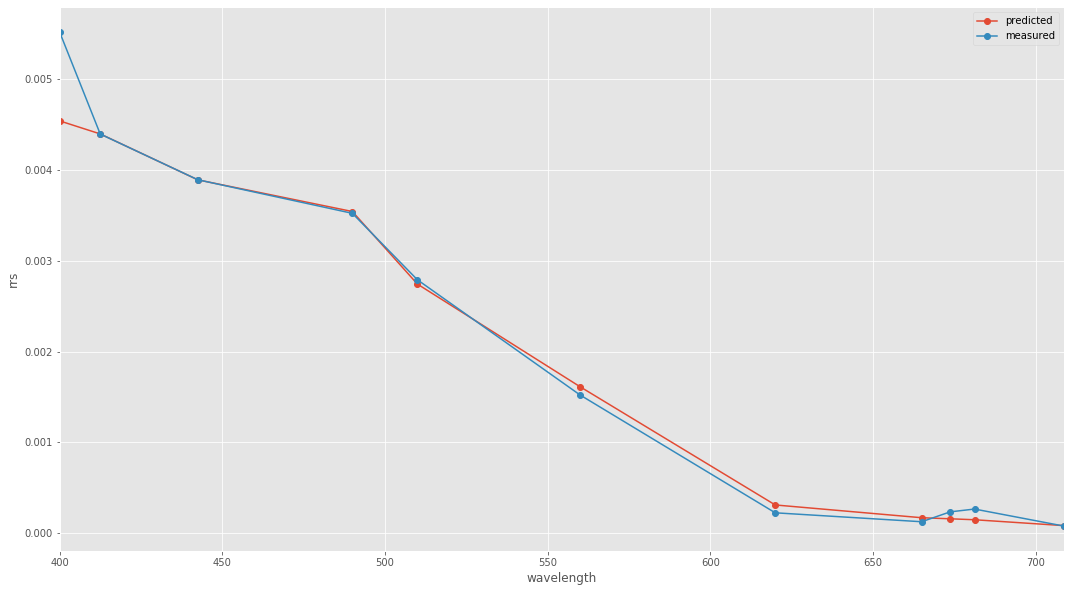

In [645]:
res_5comp.rrs.plot(marker='o', label='predicted')
olci_rrs_vis.plot(marker='o', label='measured')
plt.legend()

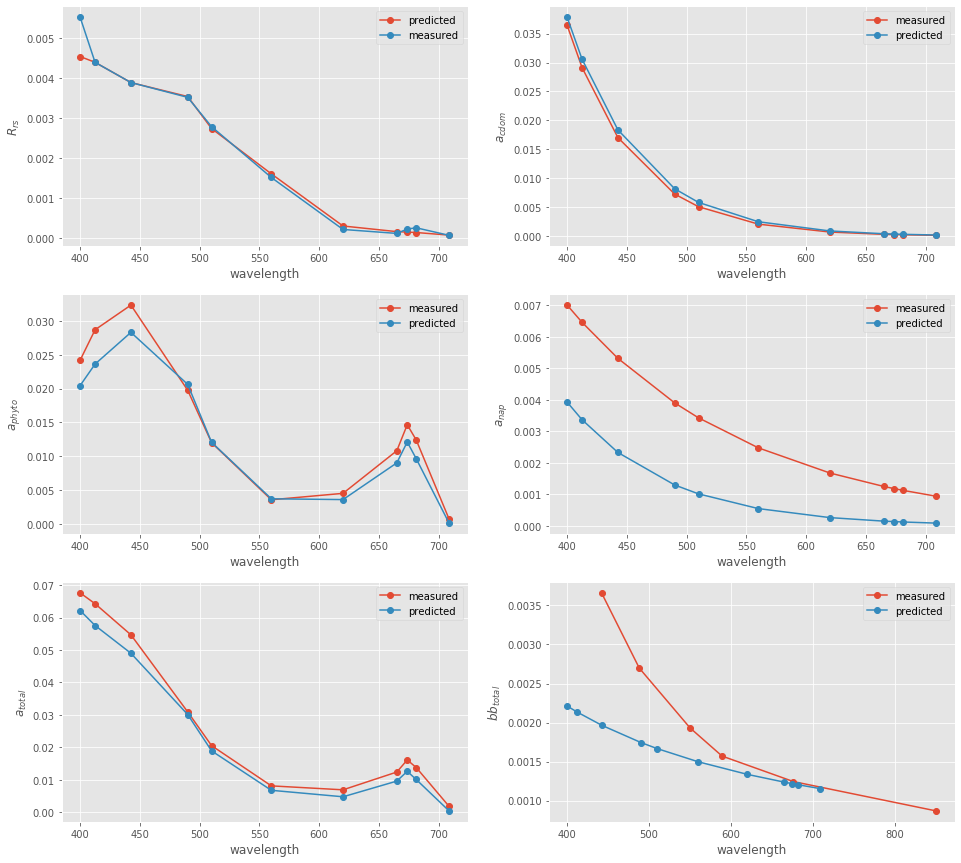

In [646]:
f, ax = plt.subplots(3,2, figsize=(16,15))

ax[0][0].plot(OLCI_WBANDS, res_5comp.rrs, marker='o', label='predicted')
ax[0][0].plot(olci_rrs_vis, marker='o', label='measured')
ax[0][0].set_xlabel('wavelength')
ax[0][0].set_ylabel('$R_{rs}$')
ax[0][0].legend()

ax[0][1].plot(OLCI_WBANDS, st019_cdom(.0178)[0]()[0], marker='o', label='measured')
ax[0][1].plot(OLCI_WBANDS, res_5comp.iops.sel(comp='cdom', iop='absorption'), marker='o', label='predicted')
ax[0][1].set_xlabel('wavelength')
ax[0][1].set_ylabel('$a_{cdom}$')
ax[0][1].legend()

ax[1][0].plot(OLCI_WBANDS, st019_aph, marker='o', label='measured')
ax[1][0].plot(OLCI_WBANDS, res_5comp.iops.sel(comp=['pico', 'nano', 'micro'], iop='absorption').sum(axis=0), marker='o', label='predicted')
ax[1][0].set_xlabel('wavelength')
ax[1][0].set_ylabel('$a_{phyto}$')
ax[1][0].legend()

ax[1][1].plot(OLCI_WBANDS, st019_nap(.175)[0]()[0], marker='o', label='measured')
ax[1][1].plot(OLCI_WBANDS, res_5comp.iops.sel(comp='nap', iop='absorption'), marker='o', label='predicted')
ax[1][1].set_xlabel('wavelength')
ax[1][1].set_ylabel('$a_{nap}$')
ax[1][1].legend()

ax[2][0].plot(OLCI_WBANDS, a_tot, marker='o', label='measured')
ax[2][0].plot(OLCI_WBANDS, res_5comp.iops.sel(iop='absorption').sum(axis=0), marker='o', label='predicted')
ax[2][0].set_xlabel('wavelength')
ax[2][0].set_ylabel('$a_{total}$')
ax[2][0].legend()

ax[2][1].plot(st019_bb_tot, marker='o', label='measured')
ax[2][1].plot(OLCI_WBANDS, res_5comp.iops.sel(iop='backscatter').sum(axis=0), marker='o', label='predicted')
ax[2][1].set_xlabel('wavelength')
ax[2][1].set_ylabel('$bb_{total}$')
ax[2][1].legend()

# plt.plot(st019_bb_tot, label='measured')
# res.iops.sel(iop='backscatter').sum(axis=0).plot(label='predicted')

### Validation

In [654]:
psc_chla = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/psc_hplc_frac.csv', index_col='depth').loc[5]

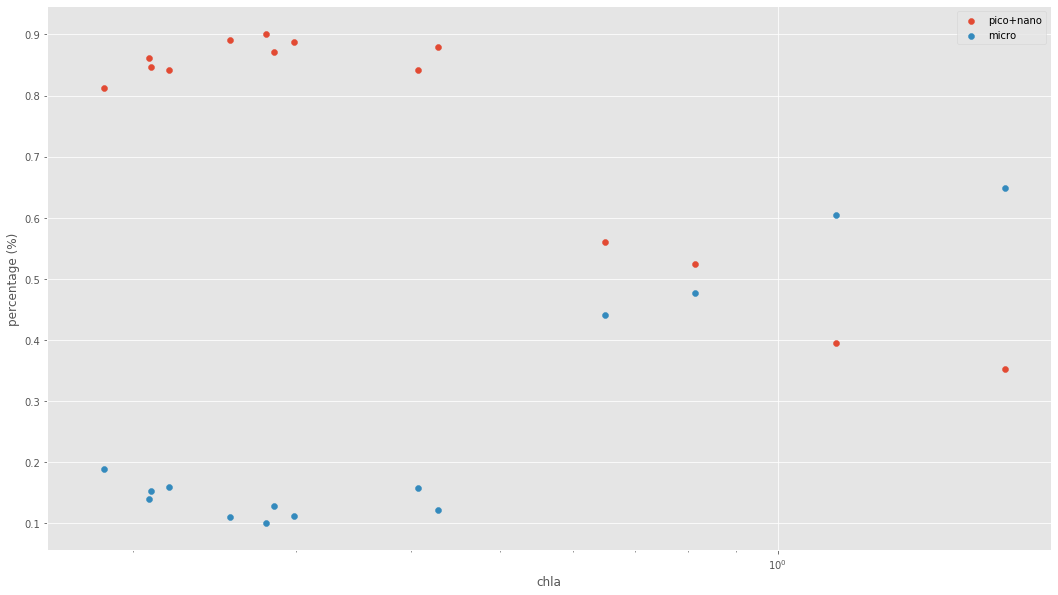

In [675]:
plt.scatter(psc_chla.chla, (psc_chla.chla_pico+psc_chla.chla_nano)/(psc_chla.chla), label='pico+nano')
plt.scatter(psc_chla.chla, (psc_chla.chla_micro)/(psc_chla.chla), label='micro')
plt.xlabel('chla')
plt.ylabel('percentage (%)')
plt.xscale('log')
plt.legend()

In [402]:
def to_type(x):
    try:
        return float(x)
    except:
        return x

In [491]:
# get 3x3-window OLCI spectra for all stations
olci_rrs_w3 = olci_rrs\
                .set_index(['window', 'flag'])\
                .loc[3, False]

olci_rrs_w3.columns = [to_type(i) for i in olci_rrs_w3.columns]

/Users/tadzio/anaconda3/envs/hydropt-4-sent3/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


In [543]:
station_inv = []
for i, row in olci_rrs_w3.iterrows():
    # replace negative values by zero
    rho = row[OLCI_WBANDS].map(lambda x: max(0, x))
    rrs = rho/np.pi
    out = inv_olci_5comp.invert(x0_1, rrs, w=weights)
    station_inv.append((row.station_id, out))

In [544]:
bbx = pd.DataFrame(
    {
        'station_id': [int(i[0]) for i in station_inv],
        'pico': [float(i[1].conc.sel(comp='pico')) for i in station_inv],
        'nano': [float(i[1].conc.sel(comp='nano')) for i in station_inv],
        'micro': [float(i[1].conc.sel(comp='micro')) for i in station_inv]
    })

In [545]:
bbx['chla'] = bbx.pico + bbx.nano + bbx.micro

In [546]:
# load validation data
csiro_validation = pd.read_csv('/Users/tadzio/Desktop/Wozniak_data/psc_hplc_frac.csv')

In [547]:
csiro_validation = csiro_validation.set_index('depth').loc[5].reset_index()

In [548]:
all_data = bbx.merge(csiro_validation, on='station_id')
all_data['chl_tot'] = all_data.chla_micro + all_data.chla_nano + all_data.chla_pico

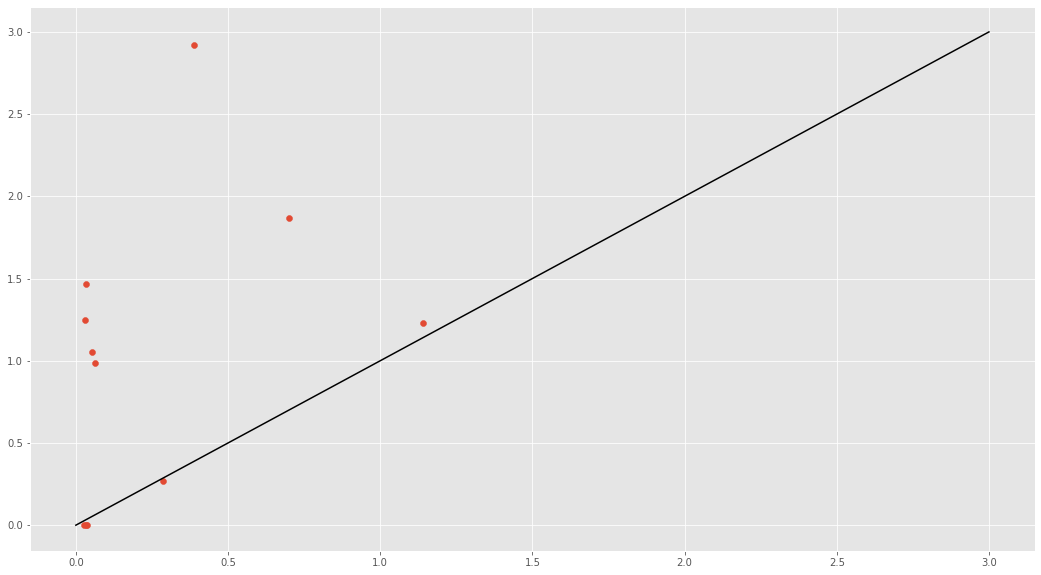

In [554]:
plt.scatter(all_data.chla_micro, all_data.micro)
plt.plot([0,3], [0,3], color='black')